#                  Segmentation des clients du site E-Commerce Olist

Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication.
L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps (dans le but d'établir un contrat de maintenance).

Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaire

# Sommaire

1. Clustering avec l'algorithme du K-Means
2. Réduction dimensionnelle - PCA
3. K-Means après réduction de dimenssions
4. Stabilité à l'initialisation du K-Means
5. Clustering avec l'algorithme du K-Prototypes
6. Stabilité temporelle de la segmentation
7. Clustering avec DBSCAN
8. Herarchiqual clustering selon Ward

In [1]:
!pip install kmodes

In [2]:
# Standards Librairies import
%matplotlib inline
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes

# Personnal scripts
import olist_functions as fct

mpl.rcParams["figure.figsize"] = (12, 8)
init_notebook_mode()
warnings.filterwarnings('ignore')

In [3]:
# root path for cleaned dataset
root_path = '../input/segmentation-des-clients-d-un-site-e-commerce-nb1'
data = pd.read_csv(root_path + "/olist-customers-segmentation.csv",
                   index_col=0)
data.head(6)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   
0004bd2a26a76fe21f786e4fbd80607f          1       166.98   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   
0000f6ccb0745a6a4b88665a16c9f078                      1.0   
0004aac84e0df4da2b147fca70cf8255                      1.0   
0004bd2a26a76fe21f786e4fbd80607f                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   
0000f6ccb0745a6a4b88665a16c9f078                        4.0   
0004aac84e0df4da2b147fca70cf8255                        6.0   
0004bd2a26a76fe21f786e4fbd80607f                        8.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                20.0   
0004aac84e0df4da2b147fca70cf8255                5.0                13.0   
0004bd2a26a76fe21f786e4fbd80607f                4.0                 2.0   

                                  favorite_sale_month  books_cds_media  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2                    5              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5              0.0   
0000f46a3911fa3c0805444483337064                    3              0.0   
0000f6ccb0745a6a4b88665a16c9f078                   10              0.0   
0004aac84e0df4da2b147fca70cf8255                   11              0.0   
0004bd2a26a76fe21f786e4fbd80607f                    4              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   
0000f6ccb0745a6a4b88665a16c9f078                           0.0            0.0   
0004aac84e0df4da2b147fca70cf8255                           0.0            0.0   
0004bd2a26a76fe21f786e4fbd80607f                           0.0            0.0   

                                  ...  total_items  mean_nb_items  \
customer_unique_id                ...                               
0000366f3b9a7992bf8c76cfdf3221e2  ...          1.0            1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...          1.0            1.0   
0000f46a3911fa3c0805444483337064  ...          1.0            1.0   
0000f6ccb0745a6a4b88665a16c9f078  ...          1.0            1.0   
0004aac84e0df4da2b147fca70cf8255  ...          1.0            1.0   
0004bd2a26a76fe21f786e4fbd80607f  ...          1.0            1.0   

                                  order_mean_delay  freight_ratio  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfd

In [4]:
data.shape

(93358, 27)

# Clustering avec l'algorithme du K-Means

## Explication de l'algorithme

 K-Means C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes *(ou clusters).

Après avoir initialisé des centroïdes en prenant des données au hasard dans le jeu de données, K-means alterne plusieurs fois ces deux étapes pour optimiser les centroïdes et leurs groupes : 

1. Regrouper chaque objet autour du centroïde le plus proche. 
2. Replacer chaque centroïde selon la moyenne des descripteurs de son groupe.

L’algorithme a convergé après un certain nombre d'itérations et trouve un découpage stable du jeu de données. Cependant, le nombre de Clusters est à définir par l'utilisateur. 

## Méthode du coude
 
KElbowVisualizer de Yellowbrick implémente la méthode du «coude» pour sélectionner le nombre optimal de clusters en ajustant le modèle K-Means avec une plage de valeurs pour K. Si le graphique en courbes ressemble à un bras, alors le «coude» (le point d'inflexion sur la courbe) est une bonne indication du nombre de K optimal.

# Preprocessing

Nous allons supprimer customer_zip_code_prefix et customer_city, customer_state pour ne conserver que la variable haversine_distance pour indiquer une localisation "large" des clients, ce qui évitera de focaliser la segmentation sur la localisation du client.

Nous allons également supprimer mean_price_order et mean_nb_items puisque nous avons vu dans le Notebook de nettoyage et exploration Olist que ces variables sont fortement corrélées aux totaux pour le moment.

In [5]:
data.drop(["customer_zip_code_prefix",
           "customer_city",
           "customer_state",
           "Flag and name",
           "mean_price_order",
           "mean_nb_items"], axis=1, inplace=True)

In [6]:
categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

[]

In [7]:
numerical_features = list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['nb_orders',
 'total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'favorite_sale_month',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'groceries_food_drink',
 'health_beauty',
 'home_furniture',
 'other',
 'sport',
 'technology',
 'toys_baby',
 'total_items',
 'order_mean_delay',
 'freight_ratio',
 'harvesine_distance']

On prepare ensuite le preprocessor :

In [8]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

Méthode du coude : détermination du meilleur K
Un pipeline SKLearn est créé pour y inclure le preprocessing et la visualisation de la méthode du coude de notre KMeans.

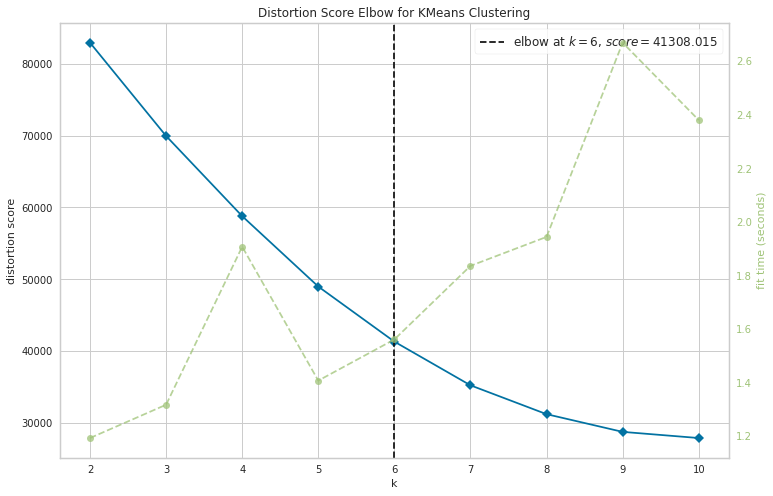

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
X = data.copy()
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segementation en  K=6 clusters serait la meilleure option

# Coefficient de silhouette

Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

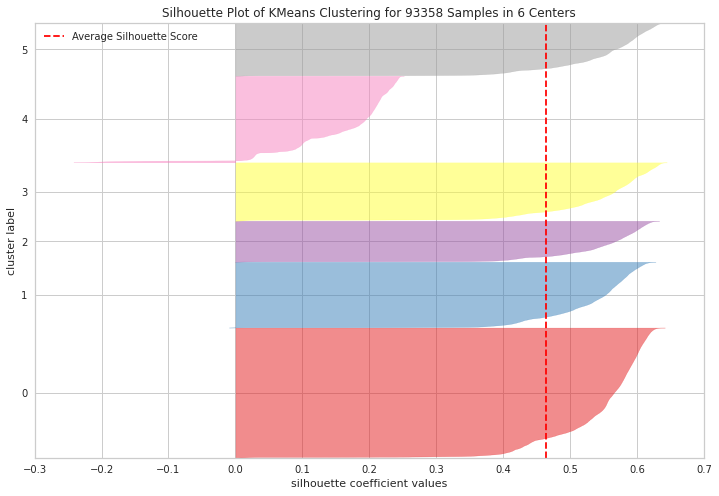

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93358 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :

* Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
* Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

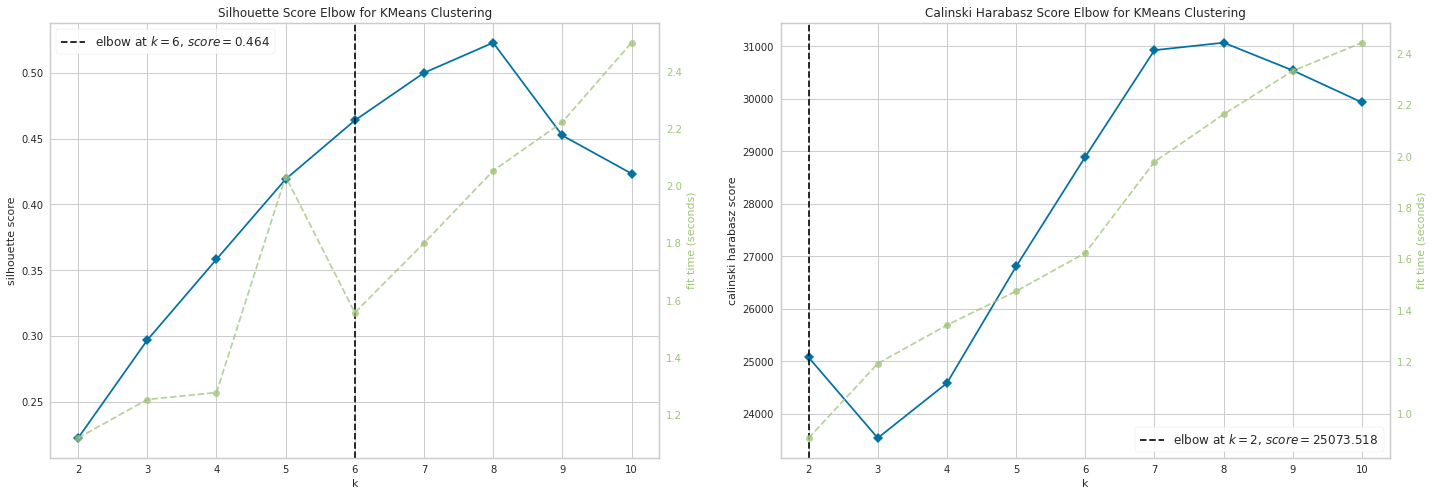

In [11]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

On remarque ici que pour la métrique silhouette score, le nombre de K est également de 6. Pour le score Calinski Harabasz, le meilleur K est plus incertain. Les scores sur la répartition en 6 clusters semblent être meilleurs. Nous allons donc conserver ce clustering en 6 groupes

# Distances intercluster

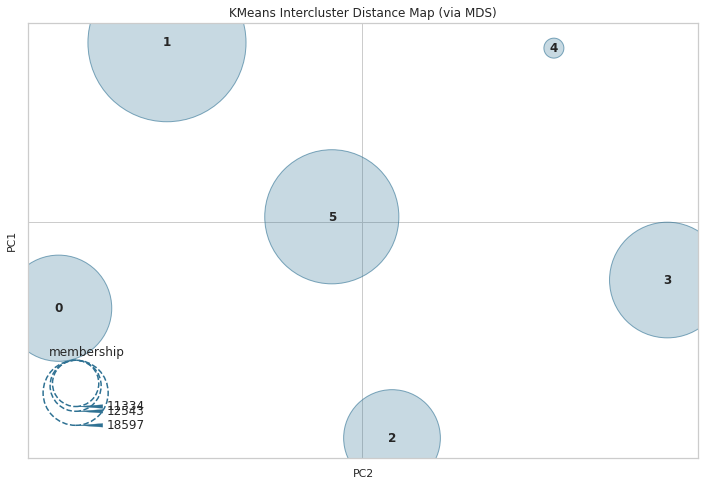

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [12]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.

Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [13]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [14]:
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

kmeans_label  nb_orders  total_spend  mean_payment_sequential  \
0             0   1.041692   163.841072                 1.055670   
1             1   1.022419   145.906736                 1.036268   
2             2   1.030732   178.660194                 1.041620   
3             3   1.031239   163.851760                 1.034180   
4             4   1.029716   176.421061                 1.042888   
5             5   1.041371   155.216072                 1.034882   

   mean_payment_installments  mean_review_score  mean_delivery_days  \
0                   3.289310           4.084059           12.977221   
1                   2.258817           4.095528           13.086800   
2                   2.841204           4.182718           12.144531   
3                   3.146552           4.246205           12.028555   
4                   3.160994           4.214361           12.117465   
5                   2.483603           4.238966           12.240382   

   favorite_sale_month  books_cds_media  fashion_clothing_accessories  ...  \
0             6.045908         0.000137                      0.000701  ...   
1             5.696110         0.000035                      0.000674  ...   
2             5.864252         0.000199                      0.001222  ...   
3             6.068374         0.000176                      0.000587  ...   
4             6.345756         0.041708                      0.155261  ...   
5             6.031620         0.000000                      0.000864  ...   

   health_beauty  home_furniture     other     sport  technology  toys_baby  \
0       0.000634        0.993458  0.001469  0.000479    0.001412   0.001358   
1       0.000371        0.001642  0.000377  0.000501    0.995643   0.000377   
2       0.001693        0.005176  0.986757  0.001401    0.002099   0.001208   
3       0.992083        0.002662  0.000585  0.001506    0.001188   0.000565   
4       0.000934        0.003013  0.001557  0.000802    0.001324   0.314045   
5       0.000752        0.003329  0.000483  0.991731    0.001275   0.000801   

   total_items  order_mean_delay  freight_ratio  harvesine_distance  
0     1.278054        236.708142       0.216124          399.690657  
1     1.153748        236.355852       0.259976          472.008312  
2     1.156369        210.987460       0.204213          434.027261  
3     1.130060        221.692108       0.188471          464.135405  
4     1.109968        241.290152       0.177530          456.060466  
5     1.170915        238.629259       0.198734          426.381922  

[6 rows x 22 columns]

In [15]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

nb_orders  total_spend  mean_payment_sequential  \
kmeans_label                                                    
0              0.002978     0.011297                 0.002227   
1              0.001601     0.009983                 0.001451   
2              0.002195     0.012382                 0.001665   
3              0.002231     0.011298                 0.001367   
4              0.002123     0.012218                 0.001716   
5              0.002955     0.010665                 0.001395   

              mean_payment_installments  mean_review_score  \
kmeans_label                                                 
0                              0.126512           0.771015   
1                              0.086878           0.773882   
2                              0.109277           0.795680   
3                              0.121021           0.811551   
4                              0.121577           0.803590   
5                              0.095523           0.809741   

              mean_delivery_days  favorite_sale_month  books_cds_media  \
kmeans_label                                                             
0                       0.057307             0.458719         0.000137   
1                       0.057832             0.426919         0.000035   
2                       0.053323             0.442205         0.000199   
3                       0.052768             0.460761         0.000176   
4                       0.053194             0.485978         0.041708   
5                       0.053782             0.457420         0.000000   

              fashion_clothing_accessories  flowers_gifts  ...  health_beauty  \
kmeans_label                                               ...                  
0                                 0.000701       0.000193  ...       0.000634   
1                                 0.000674       0.000108  ...       0.000371   
2                                 0.001222       0.000104  ...       0.001693   
3                                 0.000587       0.000044  ...       0.992083   
4                                 0.155261       0.437529  ...       0.000934   
5                                 0.000864       0.000081  ...       0.000752   

              home_furniture     other     sport  technology  toys_baby  \
kmeans_label                                                              
0                   0.993458  0.001469  0.000479    0.001412   0.001358   
1                   0.001642  0.000377  0.000501    0.995643   0.000377   
2                   0.005176  0.986757  0.001401    0.002099   0.001208   
3                   0.002662  0.000585  0.001506    0.001188   0.000565   
4                   0.003013  0.001557  0.000802    0.001324   0.314045   
5                   0.003329  0.000483  0.991731    0.001275   0.000801   

              total_items  order_mean_delay  freight_ratio  harvesine_distance  
kmeans_label                                                                    
0                0.012089          0.331989       0.225129            0.147127  
1                0.006685          0.331495       0.270808            0.183674  
2                0.006799          0.295915       0.212721            0.164480  
3                0.005655          0.310929       0.196324            0.179695  
4                0.004781          0.338415       0.184927            0.175615  
5                0.007431          0.334683       0.207014            0.160616  

[6 rows x 21 columns]

Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [16]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [17]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

Malheureusement ici, la segmentation se base principalement sur les catégories de produit achetées. Le poids de ces features masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables (nous pourrons ensuite ajouter la valeur la plus fréquente pour chaque groupe)

# Clustering sans les catégories produits

In [18]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X_bis = X.drop(categories_col, axis=1)
X_bis.head(6)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   
0004bd2a26a76fe21f786e4fbd80607f          1       166.98   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   
0000f6ccb0745a6a4b88665a16c9f078                      1.0   
0004aac84e0df4da2b147fca70cf8255                      1.0   
0004bd2a26a76fe21f786e4fbd80607f                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   
0000f6ccb0745a6a4b88665a16c9f078                        4.0   
0004aac84e0df4da2b147fca70cf8255                        6.0   
0004bd2a26a76fe21f786e4fbd80607f                        8.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                20.0   
0004aac84e0df4da2b147fca70cf8255                5.0                13.0   
0004bd2a26a76fe21f786e4fbd80607f                4.0                 2.0   

                                  favorite_sale_month  total_items  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                    5          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5          1.0   
0000f46a3911fa3c0805444483337064                    3          1.0   
0000f6ccb0745a6a4b88665a16c9f078                   10          1.0   
0004aac84e0df4da2b147fca70cf8255                   11          1.0   
0004bd2a26a76fe21f786e4fbd80607f                    4          1.0   

                                  order_mean_delay  freight_ratio  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2             111.0           0.08   
0000b849f77a49e4a4ce2b2a4ca5be3f             114.0           0.30   
0000f46a3911fa3c0805444483337064             537.0           0.20   
0000f6ccb0745a6a4b88665a16c9f078             321.0           0.40   
0004aac84e0df4da2b147fca70cf8255             288.0           0.09   
0004bd2a26a76fe21f786e4fbd80607f             146.0           0.08   

                                  harvesine_distance  
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2          209.713834  
0000b849f77a49e4a4ce2b2a4ca5be3f          209.713834  
0000f46a3911fa3c0805444483337064          125.363853  
0000f6ccb0745a6a4b88665a16c9f078         1574.231129  
0004aac84e0df4da2b147fca70cf8255          209.713834  
0004bd2a26a76fe21f786e4fbd80607f          209.713834

In [19]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

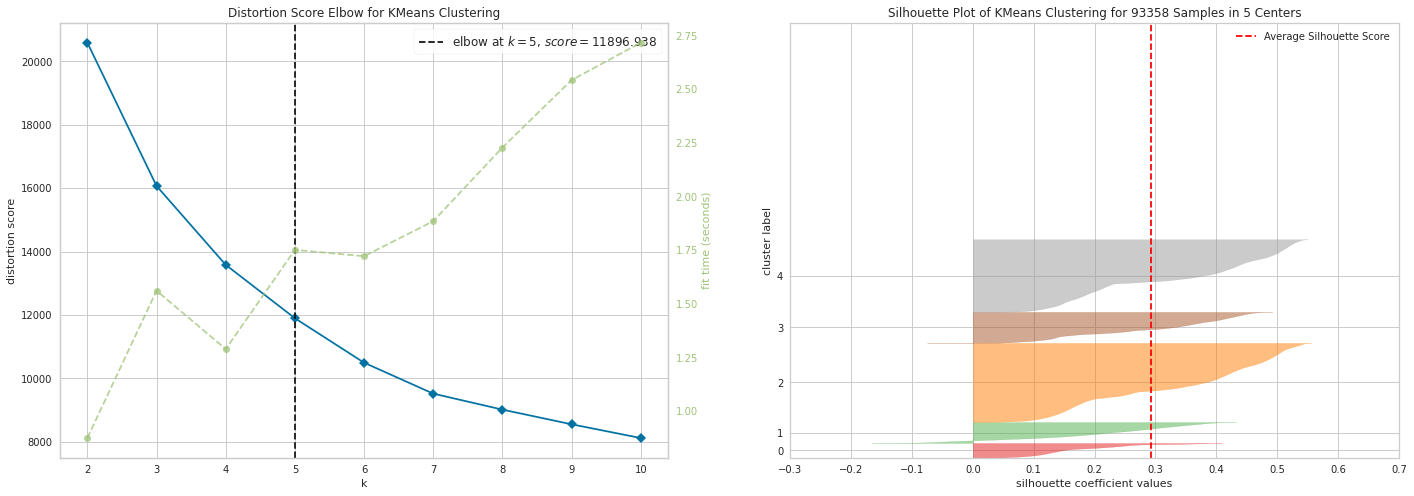

In [20]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_bis, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [21]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis)

# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis.index, columns=X_bis.columns)
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

# Group by cluster
X_scaled_clusters_bis = X_scaled_bis.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters_bis,
            group="kmeans_label")

# Interprétation métier des clusters

* Groupe 1 : Clients proches géographiquement avec de courts délais de livraison, commandant principalement en début d'année pour des montants faibles. Ils paient avec 1 type de moyen de paiement et avec un nombre faible d'échéances. Les avis de ces clients sont très bons.
* Groupe 2 : Clients de fin d'année. Ils règlent avec plusieurs moyens de paiement pour des montants faibles. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons.
* Groupe 3 : Regroupe les clients qui utilisent plusieurs moyens de paiement et un nombre important d'échéances. Ils ont tendence à espacer les délais entre 2 commandes. Les avis de ces clients sont également très bons.
* Groupe 4 : Ce sont des clients mécontants (les avis sont mauvais). Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont le plus dépensé et ont acheté un grand nombre d'articles. En revanche, le nombre de commandes passées sur le site est moyen.
* Groupe 5 : Ces clients ont passé un nombre important de commandes et sont satisfaits. ils paient comptant pour un montant moyen de commande. Ils sont géographiquement proches.

Nous allons à présent réaliser une réduction dimensionnelle pour vérifier si le clustering est réalisable sur un nombre réduit de variables sans perturber les groupes

# Réduction dimensionnelle - PCA

Nous allons réaliser une Analyse en Composantes Principales pour vérifier s'il est possible de catégoriser nos clients avec moins de variables. L'objectif étant de conserver une inertie de 95%

In [22]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis)
X_projected = pca.transform(X_bis)

## Eboulis des valeurs propres

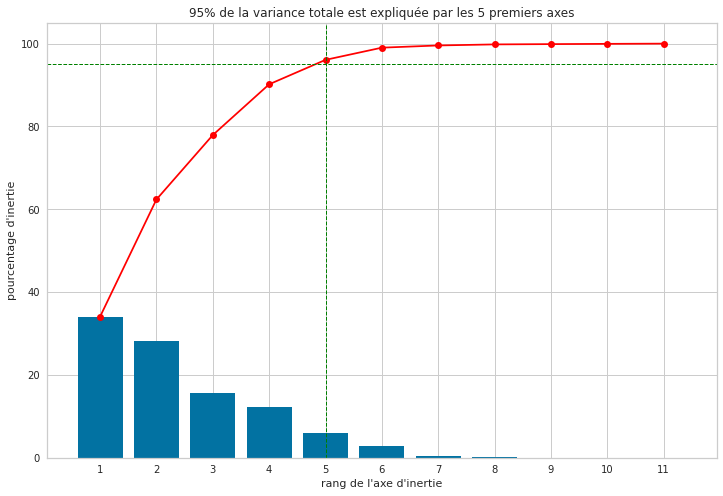

In [23]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

Il faut donc conserver 5 axes principaux pour expliquer la variance à 95%

# Cercle des corrélations

In [24]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

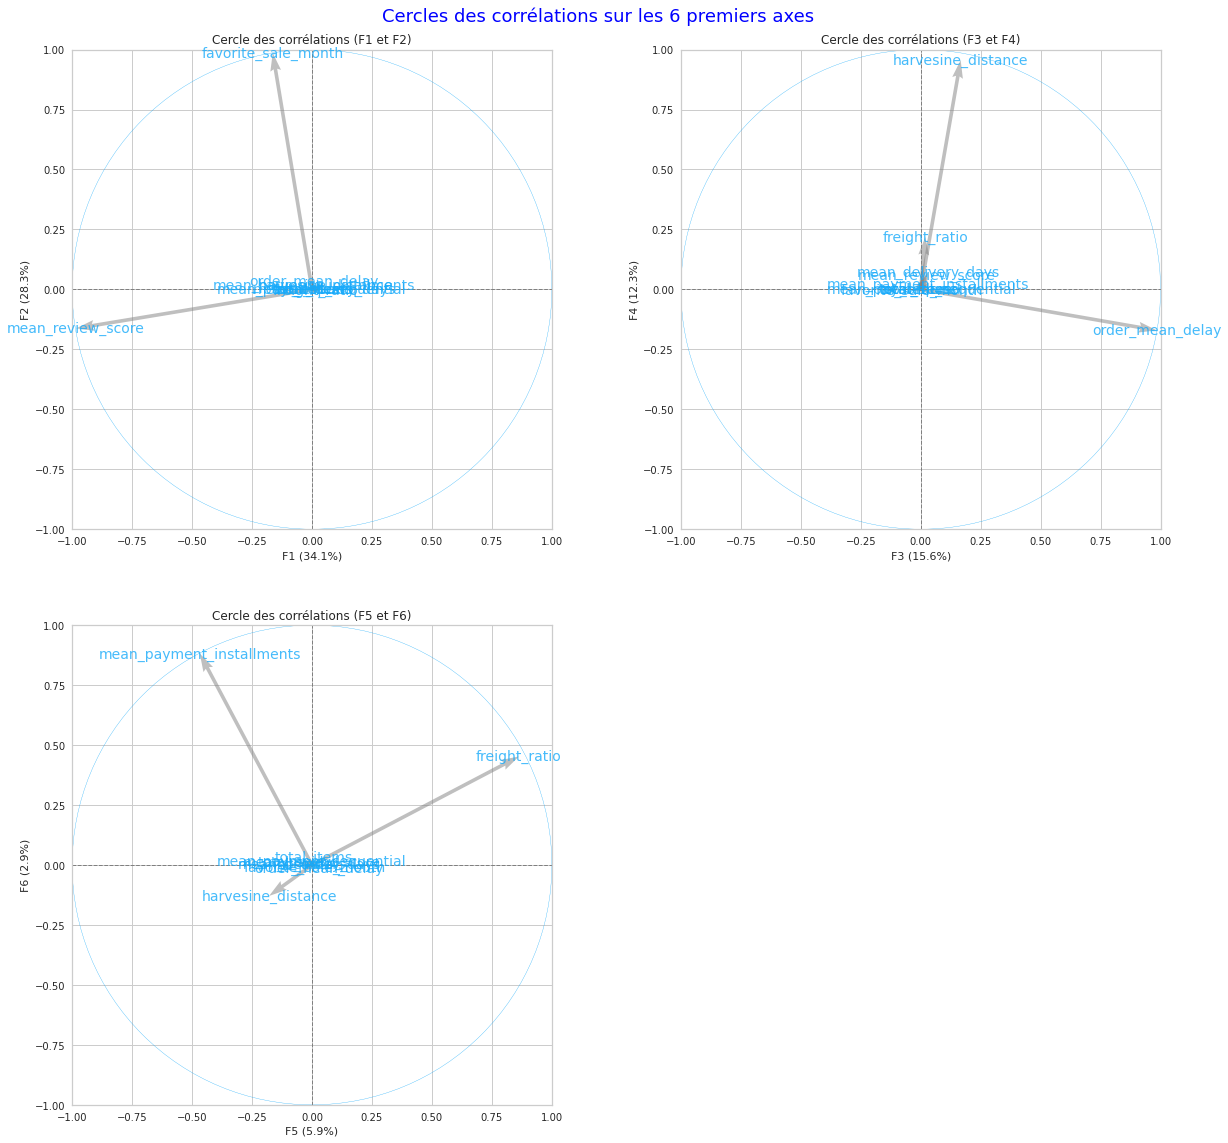

In [25]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(X_bis.columns))

On peut ainsi voir parfaitement les variables qui contribuent le plus à chaque axe. Par exemple, 

* la variable synthétique F2 représentera les périodes d'achats.

* La variable synthétique F4 quant à elle représente l'aspect géographique.

Nous allons donc intégrer à notre pipeline Kmeans une PCA sur 5 composantes pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation 

# K-Means après réduction de dimenssions

In [26]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:4])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_bis["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_bis.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

nb_orders  total_spend  mean_payment_sequential  \
kmeans_label_pca                                                    
0                  0.005081     0.011747                 0.001476   
1                  0.000010     0.010851                 0.002375   
2                  0.001877     0.013436                 0.001889   
3                  0.002689     0.010787                 0.001593   
4                  0.001068     0.010877                 0.001723   

                  mean_payment_installments  mean_review_score  \
kmeans_label_pca                                                 
0                                  0.110054           0.906667   
1                                  0.122659           0.893357   
2                                  0.124034           0.064174   
3                                  0.104827           0.887974   
4                                  0.116626           0.893833   

                  mean_delivery_days  favorite_sale_month  total_items  \
kmeans_label_pca                                                         
0                           0.038309             0.502637     0.008834   
1                           0.051815             0.341962     0.004923   
2                           0.091892             0.436944     0.015227   
3                           0.056195             0.136158     0.006715   
4                           0.054090             0.837374     0.005829   

                  order_mean_delay  freight_ratio  harvesine_distance  
kmeans_label_pca                                                       
0                         0.083432       0.219701            0.154112  
1                         0.669438       0.219167            0.172872  
2                         0.324509       0.222255            0.191966  
3                         0.247261       0.214391            0.157179  
4                         0.436198       0.211531            0.169507

In [27]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

5

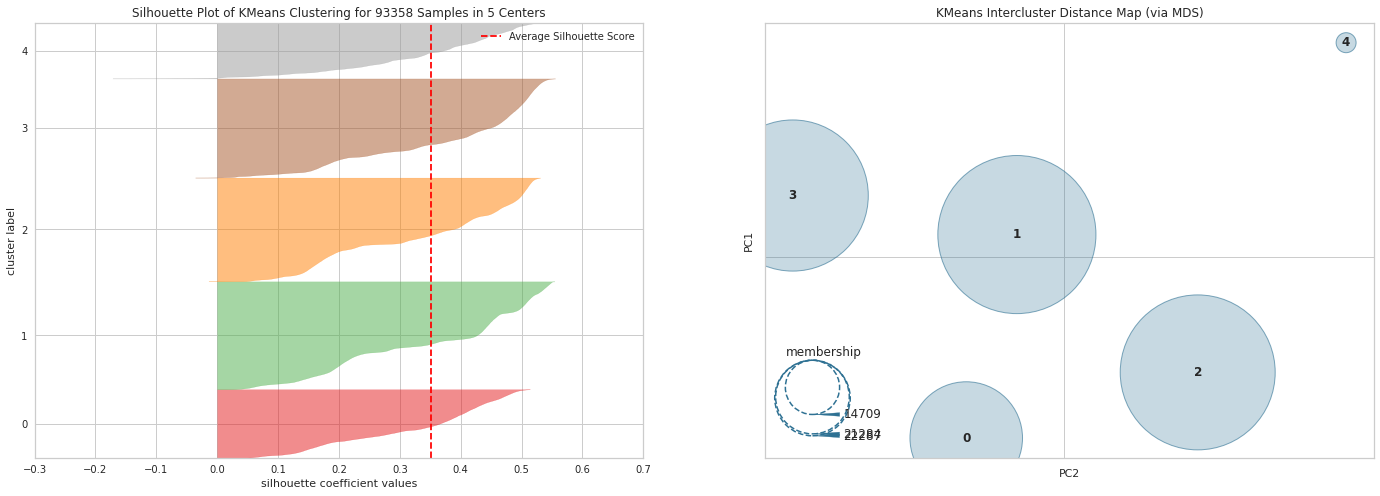

In [28]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:4], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

On remarque donc ici que la réduction de dimenssion offre les mêmes axes de segmentation. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter notre fichier client, ce d'autant que les scores silhouette sont ici meilleurs comparés au données brutes.

# Stabilité à l'initialisation du K-Means

Notre algorithme du K-Means testé ici est initialisé avec la méthode K-Means++, ce qui réduit déjà les effets aléatoires de l'initialisation des centroïdes. Cependant, vous allons tester la stabilité à l'initialisation en entrainant plusieurs fois le modèle sans fixer le RandomState.

Pour les labels initiaux, nous allons conserver les clusters calculés dans le dernier modèle (avec PCA) puis les comparer grâce à l'indice de Rand ajusté (ARI) pour chacune des itérations.

In [29]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:4]

In [30]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [31]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=pca_data, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.250s	6642	0.630	0.582	0.647
Iter 1   	0.155s	6562	0.719	0.631	0.752
Iter 2   	0.131s	6650	0.683	0.606	0.716
Iter 3   	0.158s	6642	0.630	0.582	0.646
Iter 4   	0.193s	6668	0.616	0.566	0.632
Iter 5   	0.181s	6562	0.725	0.635	0.759
Iter 6   	0.197s	6160	0.999	1.000	0.999
Iter 7   	0.179s	6719	0.728	0.647	0.772
Iter 8   	0.134s	6546	0.645	0.588	0.657
Iter 9   	0.216s	6160	0.999	1.000	0.999
_____________________________________________________


Les différentes itérations montrent des inerties proches, une bonne homogénéité et un score AMI proche de 1. Nous pouvons donc en déduire que la stabilité à l'initialisation du modèle K-Means est bonne

# Clustering avec l'algorithme du K-Prototypes


# Explication de l'algorithme

K-Prototypes Le K-Prototype est l'algorithme de clustering qui est la combinaison de K-Means et K-Mode. Dans l'algorithme du K-modes, la distance est mesurée par le nombre d'attributs catégoriels communs partagés par les deux points de données. K-Prototypes mesure la distance entre les variables numériques à l'aide de la distance euclidienne (comme le K-Means), mais mesure également la distance entre les entités catégorielles en utilisant le nombre de catégories correspondantes. Les principales étapes sont les suivantes : 1. Sélection k prototypes initiaux dans l'ensemble de données X. Il doit y en avoir un pour chaque cluster. 2. Allouer chaque objet de X à un cluster dont le prototype est le plus proche de lui. Cette allocation se fait en considérant la mesure de dissimilarité. 3. Une fois tout les objets alloués à un cluster, tester à nouveau la similitude des objets par rapport aux prototypes actuels. Si un individu est plus proche d'un autre cluster, les prototypes des deux clusters sont mis à jour.

Pour cet algorithme traitant les données mixtes, nous allons convertir quelques variables en variables catégorielles (comme les mois d'achat par exemple) pour leur donner plus de sens.

In [32]:
X_ter = X.iloc[:,:-1]
X_ter["favorite_sale_month"] = pd.to_datetime(X_ter["favorite_sale_month"], format='%m').dt.month_name()
X_ter["mean_payment_sequential"] = np.where(X_ter["mean_payment_sequential"] > 1, "Multiple", "Single")
X_ter["mean_payment_installments"] = np.where(X_ter["mean_payment_installments"] > 1, "Multiple", "Single")
X_ter.head(6)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   
0004bd2a26a76fe21f786e4fbd80607f          1       166.98   

                                 mean_payment_sequential  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2                  Single   
0000b849f77a49e4a4ce2b2a4ca5be3f                  Single   
0000f46a3911fa3c0805444483337064                  Single   
0000f6ccb0745a6a4b88665a16c9f078                  Single   
0004aac84e0df4da2b147fca70cf8255                  Single   
0004bd2a26a76fe21f786e4fbd80607f                  Single   

                                 mean_payment_installments  mean_review_score  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                  Multiple                5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    Single                4.0   
0000f46a3911fa3c0805444483337064                  Multiple                3.0   
0000f6ccb0745a6a4b88665a16c9f078                  Multiple                4.0   
0004aac84e0df4da2b147fca70cf8255                  Multiple                5.0   
0004bd2a26a76fe21f786e4fbd80607f                  Multiple                4.0   

                                  mean_delivery_days favorite_sale_month  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2                 6.0                 May   
0000b849f77a49e4a4ce2b2a4ca5be3f                 3.0                 May   
0000f46a3911fa3c0805444483337064                26.0               March   
0000f6ccb0745a6a4b88665a16c9f078                20.0             October   
0004aac84e0df4da2b147fca70cf8255                13.0            November   
0004bd2a26a76fe21f786e4fbd80607f                 2.0               April   

                                  books_cds_media  \
customer_unique_id                                  
0000366f3b9a7992bf8c76cfdf3221e2              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f              0.0   
0000f46a3911fa3c0805444483337064              0.0   
0000f6ccb0745a6a4b88665a16c9f078              0.0   
0004aac84e0df4da2b147fca70cf8255              0.0   
0004bd2a26a76fe21f786e4fbd80607f              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   
0000f6ccb0745a6a4b88665a16c9f078                           0.0            0.0   
0004aac84e0df4da2b147fca70cf8255                           0.0            0.0   
0004bd2a26a76fe21f786e4fbd80607f                           0.0            0.0   

                                  groceries_food_drink  health_beauty  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2                   0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                   0.0            1.0   
0000f46a3911fa3c0805444483337064                   0.0            0.0   
0000f6ccb0745a6a4b88665a16c9f078                   0.0            0.0   
0004aac84e0df4da2b147fca70cf8255                   0.0            0.0   
0004bd2a26a76fe21f786e4fbd80607f                   0.0            0.0   

                                  home_furniture  other  sport  technology  \
customer_unique_id                                                           

Pour l'algorithme K-Prototypes, nous n'avons pas besoin d'encoder les variables catégorielles. Nous allons donc normaliser uniquement les varaibles numériques 

In [33]:
for c in X_ter.select_dtypes(exclude="object").columns:
    scaler = MinMaxScaler()
    X_ter[c] = scaler.fit_transform(np.array(X_ter[c]).reshape(-1, 1))

In [34]:
# Categorical features index
cat_cols = [X_ter.columns.get_loc(c) for c in X_ter.select_dtypes(include="object").columns]

In [35]:
#Choosing optimal K
cost = []
for num_clusters in list(range(4,9)):
    n_clusters=num_clusters
    kproto = KPrototypes(n_clusters, init='Cao',n_init = 1,verbose=1)
    kproto.fit_predict(X_ter, categorical=cat_cols)
    cost.append(kproto.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 15892, ncost: 70771.39582515798
Run: 1, iteration: 2/100, moves: 3918, ncost: 70210.57027307704
Run: 1, iteration: 3/100, moves: 347, ncost: 70206.14649025323
Run: 1, iteration: 4/100, moves: 0, ncost: 70206.14649025323
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 24567, ncost: 58121.87125536087
Run: 1, iteration: 2/100, moves: 2229, ncost: 57711.01428315678
Run: 1, iteration: 3/100, moves: 100, ncost: 57710.99649831291
Run: 1, iteration: 4/100, moves: 0, ncost: 57710.99649831291
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 26550, ncost: 50139.67948683251
Run: 1, iteration: 2/100, moves: 3355, ncost: 49490.329826806956
Run: 1, iteration: 3/100, moves: 159, ncost: 49490.15897398521
Run: 1, iteration: 4/100, moves: 3, ncost: 49490.1585135692
R

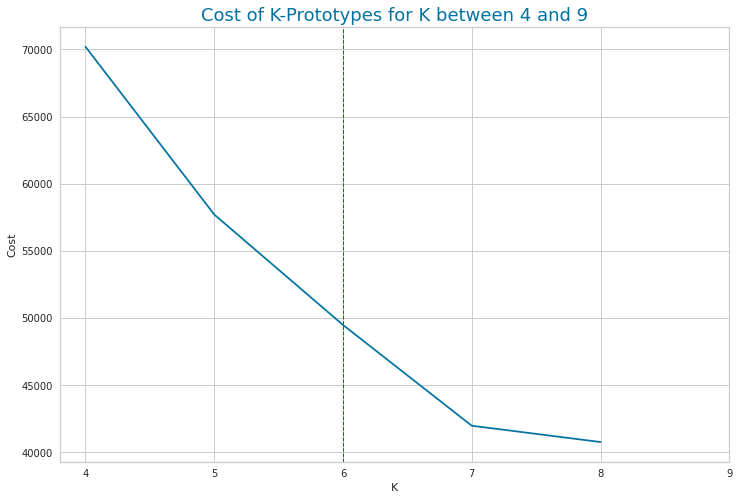

In [36]:
plt.figure(figsize=(12,8))
plt.plot(cost)
plt.xticks(np.arange(0,6,1), np.arange(4,10,1))
plt.axvline(x=2, linestyle="--", 
            color="green",
            linewidth=1)
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("Cost of K-Prototypes for K between 4 and 9",
          fontsize=18, color="b")
plt.show()

Puis on initialise l'algorithme :

In [37]:
kproto = KPrototypes(n_clusters= 6, init='Cao',n_init = 1,verbose=1)
kproto_labels = kproto.fit_predict(X_ter, categorical=cat_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 27419, ncost: 59972.29403816197
Run: 1, iteration: 2/100, moves: 5333, ncost: 58647.64610927904
Run: 1, iteration: 3/100, moves: 1480, ncost: 58433.123215936655
Run: 1, iteration: 4/100, moves: 137, ncost: 58430.82975043325
Run: 1, iteration: 5/100, moves: 7, ncost: 58430.827318079966
Run: 1, iteration: 6/100, moves: 0, ncost: 58430.827318079966


In [38]:
X_ter["kproto_labels"] = kproto_labels
X_ter.groupby("kproto_labels").mean()

nb_orders  total_spend  mean_review_score  mean_delivery_days  \
kproto_labels                                                                  
0               0.001847     0.012363           0.795334            0.053392   
1               0.002132     0.011295           0.810444            0.052757   
2               0.001989     0.011197           0.795108            0.055109   
3               0.003454     0.010996           0.929585            0.050272   
4               0.003161     0.012638           0.223379            0.081662   
5               0.001647     0.010874           0.798661            0.053155   

               books_cds_media  fashion_clothing_accessories  flowers_gifts  \
kproto_labels                                                                 
0                     0.000200                      0.001235       0.001226   
1                     0.000176                      0.000616       0.001057   
2                     0.023523                      0.089188       0.250203   
3                     0.000206                      0.000745       0.001018   
4                     0.002668                      0.003269       0.001735   
5                     0.000157                      0.001385       0.003011   

               groceries_food_drink  health_beauty  home_furniture     other  \
kproto_labels                                                                  
0                          0.000116       0.001903        0.002416  0.989558   
1                          0.000605       0.992449        0.001681  0.000321   
2                          0.024991       0.000542        0.001516  0.001034   
3                          0.000158       0.000978        0.991097  0.002353   
4                          0.003086       0.001330        0.978606  0.004098   
5                          0.000000       0.000110        0.001516  0.001046   

                  sport  technology  toys_baby  total_items  order_mean_delay  \
kproto_labels                                                                   
0              0.000848    0.001524   0.000974     0.006552          0.297150   
1              0.001472    0.001013   0.000609     0.005640          0.311551   
2              0.204253    0.404400   0.000350     0.006011          0.332663   
3              0.000842    0.001262   0.001343     0.010272          0.327816   
4              0.001494    0.001638   0.002076     0.019553          0.340242   
5              0.000863    0.001229   0.990684     0.004282          0.352612   

               freight_ratio  
kproto_labels                 
0                   0.212681  
1                   0.196381  
2                   0.221213  
3                   0.222904  
4                   0.231801  
5                   0.201349

On remarque cette fois encore que les résultats obtenus sont similaires au K-Means, les catégories produits l'emportent sur les autres variables. Le K-Prototypes ayant un temps d'entrainement et de prédiction plus long, nous conserverons donc la segmentation avec le modèle K-Means.

# Stabilité temporelle de la segmentation


Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée. Le script réalisant ces calculs est disponible dans le module annexe olist_functions

In [39]:
# Initial period of 12 months
data_init = fct.make_dataset(dpath="../input/brazilian-ecommerce/", initial=True, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 16.58s


In [40]:
# Remove categories
data_init.drop(categories_col, axis=1, inplace=True)
data_init.head(6)

nb_orders  total_items  total_spend  \
customer_unique_id                                                      
0000f46a3911fa3c0805444483337064          1            1        86.22   
0005e1862207bf6ccc02e4228effd9a0          1            1       150.12   
0006fdc98a402fceb4eb0ee528f6a8d4          1            1        29.00   
000a5ad9c4601d2bbdd9ed765d5213b3          1            1        91.28   
000de6019bb59f34c099a907c151d855          1            2       257.44   
0010a452c6d13139e50b57f19f52e04e          1            1       325.93   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000f46a3911fa3c0805444483337064                      1.0   
0005e1862207bf6ccc02e4228effd9a0                      1.0   
0006fdc98a402fceb4eb0ee528f6a8d4                      1.0   
000a5ad9c4601d2bbdd9ed765d5213b3                      1.0   
000de6019bb59f34c099a907c151d855                      1.0   
0010a452c6d13139e50b57f19f52e04e                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064                        8.0   
0005e1862207bf6ccc02e4228effd9a0                        3.0   
0006fdc98a402fceb4eb0ee528f6a8d4                        2.0   
000a5ad9c4601d2bbdd9ed765d5213b3                        3.0   
000de6019bb59f34c099a907c151d855                        4.0   
0010a452c6d13139e50b57f19f52e04e                       10.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000f46a3911fa3c0805444483337064                3.0                26.0   
0005e1862207bf6ccc02e4228effd9a0                4.0                 4.0   
0006fdc98a402fceb4eb0ee528f6a8d4                3.0                16.0   
000a5ad9c4601d2bbdd9ed765d5213b3                4.0                11.0   
000de6019bb59f34c099a907c151d855                2.0                 2.0   
0010a452c6d13139e50b57f19f52e04e                1.0                15.0   

                                  favorite_sale_month  order_mean_delay  \
customer_unique_id                                                        
0000f46a3911fa3c0805444483337064                    3             178.0   
0005e1862207bf6ccc02e4228effd9a0                    3             184.0   
0006fdc98a402fceb4eb0ee528f6a8d4                    7              48.0   
000a5ad9c4601d2bbdd9ed765d5213b3                    8              24.0   
000de6019bb59f34c099a907c151d855                    8              18.0   
0010a452c6d13139e50b57f19f52e04e                    7              55.0   

                                  freight_ratio  haversine_distance  
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064           0.20          125.363853  
0005e1862207bf6ccc02e4228effd9a0           0.10          428.916514  
0006fdc98a402fceb4eb0ee528f6a8d4           0.52          669.215559  
000a5ad9c4601d2bbdd9ed765d5213b3           0.16          337.899660  
000de6019bb59f34c099a907c151d855           0.11          209.713834  
0010a452c6d13139e50b57f19f52e04e           0.08          337.899660

Nous allons ensuite déterminer la période totale à couvrir 

In [41]:
olist_path = "../input/brazilian-ecommerce/"
orders = pd.read_csv(olist_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

Ici le déroulé est créé directement dans le notebook pour explication, en production, toutes ses opérations seront regroupées dans une classe Python pour automatiser le processus.

In [42]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [43]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = fct.make_dataset(dpath="../input/brazilian-ecommerce/", 
                                   initial=False, 
                                   period=p)
    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 20.87s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 27.82s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
_____________________________

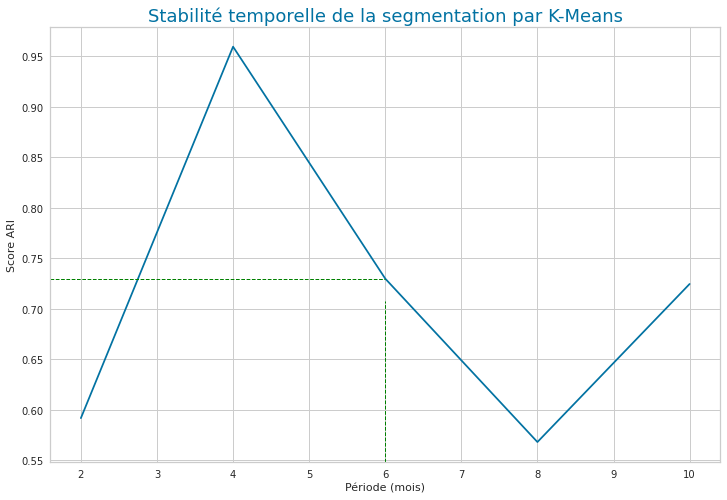

In [44]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus sur les itérations par période de 2 mois, on remarque une forte inflexion après 6 mois sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 6 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.

# CAH sur echantillon (car dataset de plus de 93000 observations)

### Classification ascendante hiérarchique


## Classification ascendante hiérarchique
   ### Utilisation du package « scipy »


In [45]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby',
                 ]
data_bis = data.drop(categories_col ,axis = 1)

In [46]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, data_bis)])

In [47]:
X = data_bis.copy()
X.head(10)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   
0004bd2a26a76fe21f786e4fbd80607f          1       166.98   
00050ab1314c0e55a6ca13cf7181fecf          1        35.38   
00053a61a98854899e70ed204dd4bafe          1       419.18   
0005e1862207bf6ccc02e4228effd9a0          1       150.12   
0005ef4cd20d2893f0d9fbd94d3c0d97          1       129.76   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   
0000f6ccb0745a6a4b88665a16c9f078                      1.0   
0004aac84e0df4da2b147fca70cf8255                      1.0   
0004bd2a26a76fe21f786e4fbd80607f                      1.0   
00050ab1314c0e55a6ca13cf7181fecf                      1.0   
00053a61a98854899e70ed204dd4bafe                      1.0   
0005e1862207bf6ccc02e4228effd9a0                      1.0   
0005ef4cd20d2893f0d9fbd94d3c0d97                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   
0000f6ccb0745a6a4b88665a16c9f078                        4.0   
0004aac84e0df4da2b147fca70cf8255                        6.0   
0004bd2a26a76fe21f786e4fbd80607f                        8.0   
00050ab1314c0e55a6ca13cf7181fecf                        1.0   
00053a61a98854899e70ed204dd4bafe                        3.0   
0005e1862207bf6ccc02e4228effd9a0                        3.0   
0005ef4cd20d2893f0d9fbd94d3c0d97                        4.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                20.0   
0004aac84e0df4da2b147fca70cf8255                5.0                13.0   
0004bd2a26a76fe21f786e4fbd80607f                4.0                 2.0   
00050ab1314c0e55a6ca13cf7181fecf                4.0                 7.0   
00053a61a98854899e70ed204dd4bafe                1.0                16.0   
0005e1862207bf6ccc02e4228effd9a0                4.0                 4.0   
0005ef4cd20d2893f0d9fbd94d3c0d97                1.0                54.0   

                                  favorite_sale_month  total_items  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                    5          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5          1.0   
0000f46a3911fa3c0805444483337064                    3          1.0   
0000f6ccb0745a6a4b88665a16c9f078                   10          1.0   
0004aac84e0df4da2b147fca70cf8255                   11          1.0   
0004bd2a26a76fe21f786e4fbd80607f                    4          1.0   
00050ab1314c0e55a6ca13cf7181fecf                    4          1.0   
00053a61a98854899e70ed204dd4bafe                    2          2.0   
0005e1862207bf6ccc02e4228effd9a0                    3          1.0   
0005ef4cd20d2893f0d9fbd94d3c0d97                    3          1.0   

                                  order_mean_delay  freight_ratio  \
customer_uni

In [48]:
# Step 3: Preprocessing the data

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [49]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.15555472 0.15230941 0.13578679 0.12397491 0.11674893 0.08836582
 0.06997681 0.04687967 0.04406848 0.02058943 0.01785058 0.01668591]
[0.15731802 0.15403593 0.13732602 0.12538024 0.11807235 0.0893675
 0.07077003 0.04741108 0.04456802 0.02082282 0.01805292 0.01687506]


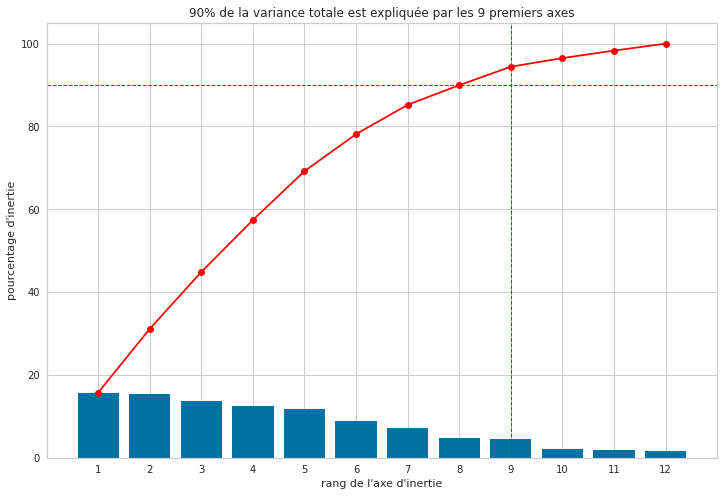

In [50]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [51]:
# 4 : Réduire la dimensionnalité des Données

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split

In [53]:
 X_train, X_test,  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

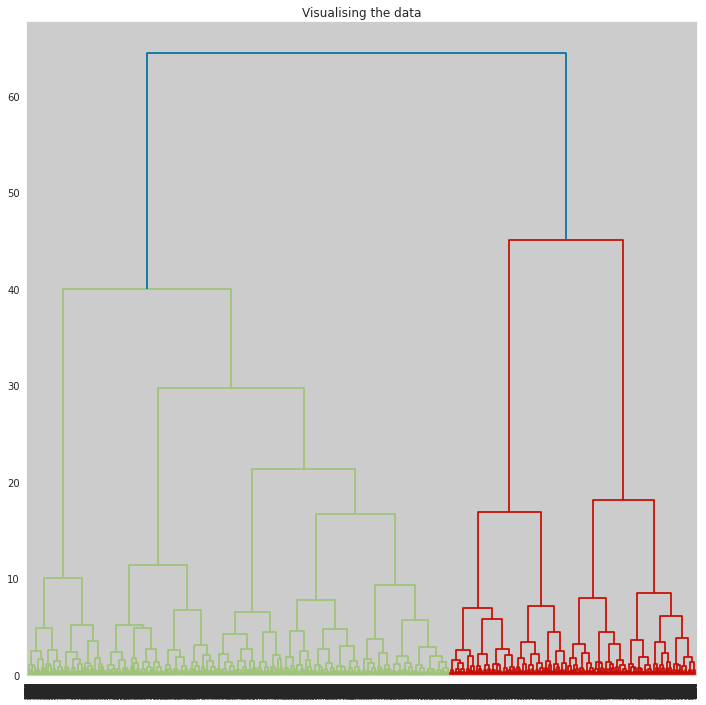

In [54]:
# Dendograms are used to divide a given cluster into many different clusters.

# Step 5: Visualizing the working of the Dendograms

plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))

In [55]:
 y_train, y_test,  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

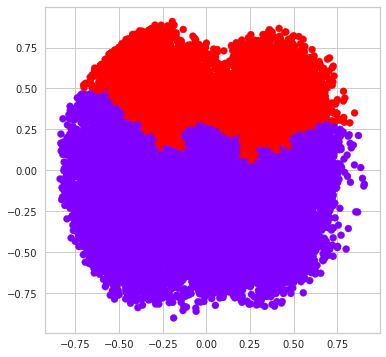

In [56]:
# Step 6: Building and Visualizing the different clustering models for different values of k
# k = 2

ac2 = AgglomerativeClustering(n_clusters = 2)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac2.fit_predict(y_test), cmap ='rainbow')
plt.show()

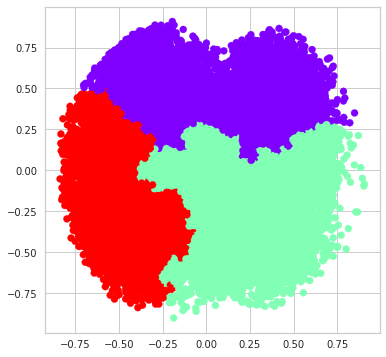

In [57]:
# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac3.fit_predict(y_test), cmap ='rainbow')
plt.show()

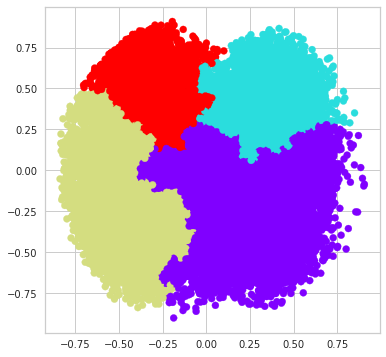

In [58]:
# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac4.fit_predict(y_test), cmap ='rainbow')
plt.show()

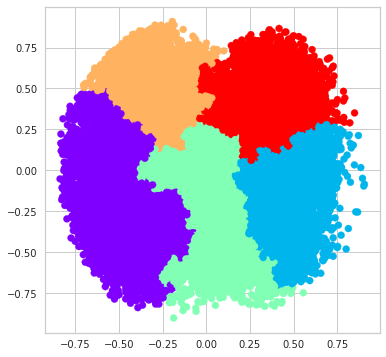

In [59]:
# k = 5

ac5 = AgglomerativeClustering(n_clusters = 5)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac5.fit_predict(y_test), cmap ='rainbow')
plt.show()

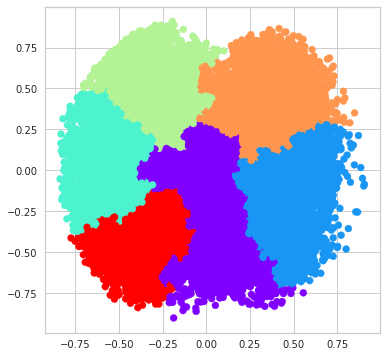

In [60]:
# k = 6

ac6 = AgglomerativeClustering(n_clusters = 6)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac6.fit_predict(y_test), cmap ='rainbow')
plt.show()

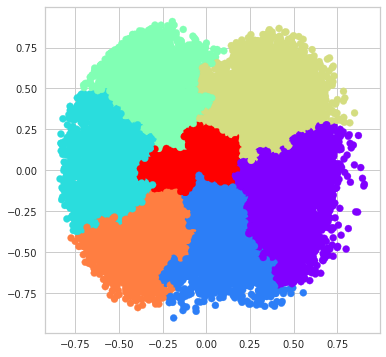

In [61]:
# k = 7

ac7 = AgglomerativeClustering(n_clusters = 7)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac7.fit_predict(y_test), cmap ='rainbow')
plt.show()

### We now determine the optimal number of clusters using a mathematical technique. Here, We will use the Silhouette Scores for the purpose.

In [62]:
# Step 7: Evaluating the different models and Visualizing the results.

# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_test, ac2.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac3.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac4.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac5.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac6.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac7.fit_predict(y_test)))

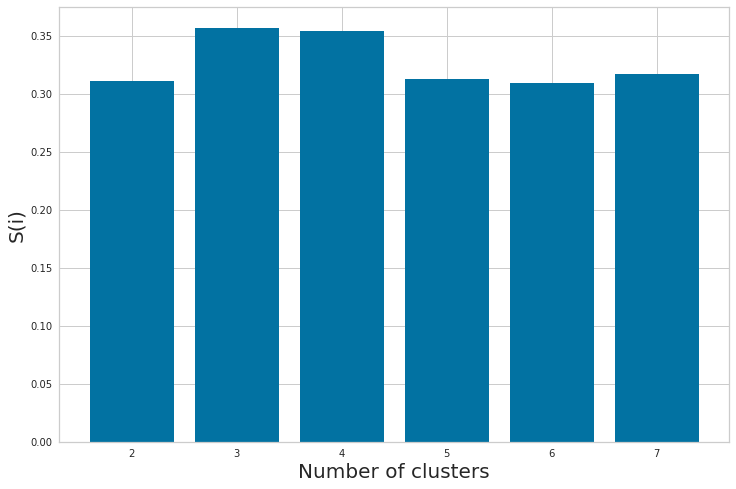

In [63]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6, 7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

### # Thus, with the help of the silhouette scores, it is concluded that the optimal number of clusters for the given data and clustering technique is 6

In [64]:
Xbis_train,Xbis_test   = train_test_split(
                     X_normalized,  test_size=0.8, random_state=0)

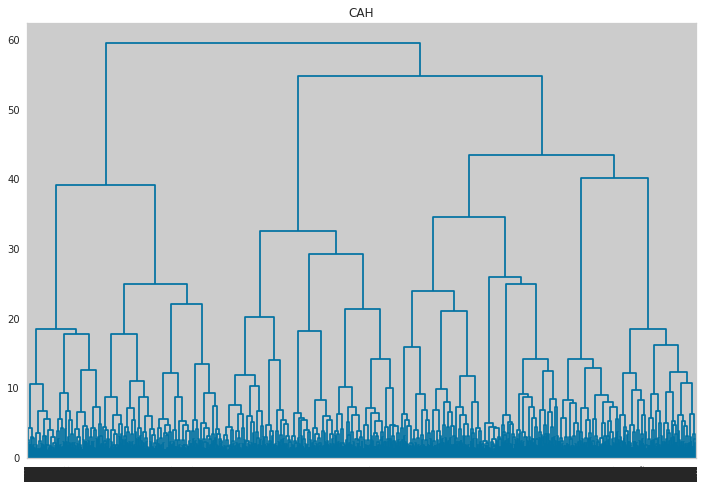

In [65]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(Xbis_train,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=Xbis_train.index,orientation='top',color_threshold=0)
plt.show()


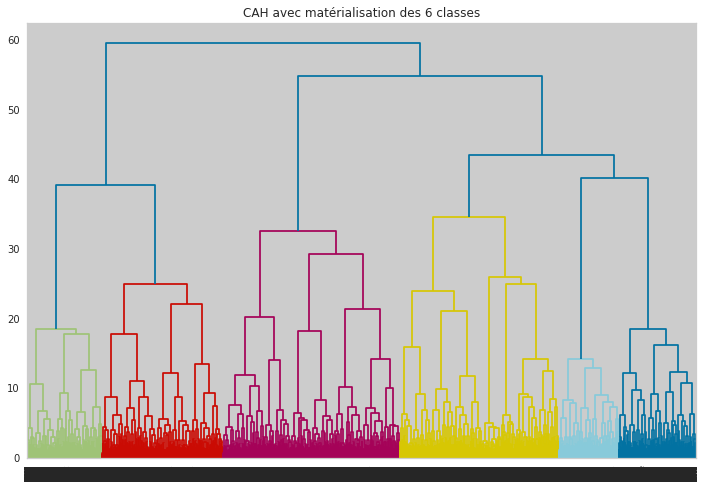

[2 2 4 ... 6 4 3]
        0
1   19410
1    2027
1   40849
1   72214
1   23129
..    ...
6   87118
6   62968
6   72534
6   50823
6   36680

[18671 rows x 1 columns]


In [66]:
from scipy.cluster.hierarchy import ward, fcluster
#matérialisation des 6 classes (hauteur t = 38
plt.title('CAH avec matérialisation des 6 classes')
dendrogram(Z,labels=Xbis_train.index,orientation='top',color_threshold=38)
plt.show()
#découpage à la hauteur t = 38==> identifiants de 6 groupes obtenus
groupes_cah = fcluster(Z,t=38,criterion='distance')
print(groupes_cah)
#index triés des groupes
idg = np.argsort(groupes_cah)
#affichage des observations et leurs groupes
print(pd.DataFrame(X_train.index[idg],groupes_cah[idg]))


In [67]:
Xbis_train = pd.DataFrame(Xbis_train, index=Xbis_train.index, columns=Xbis_train.columns)
Xbis_train_clusters = Xbis_train.mean()
Xbis_train_clusters

0    -0.035156
1    -0.041401
2    -0.024567
3    -0.036397
4     0.037481
5    -0.037922
6     0.003909
7    -0.043297
8    -0.012068
9    -0.011905
10   -0.035500
11   -0.003071
dtype: float64

# CLUSTERING PAR DBSCAN

In [68]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
labels = db_default.labels_

In [69]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [70]:
# Step 5: Building the clustering model
from sklearn import metrics
labels_true = X.index
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 6
Estimated number of noise points: 131
Homogeneity: 0.0012
Completeness: 1.0000
V-measure: 0.0024
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: -0.0000
Silhouette Coefficient: -0.2643


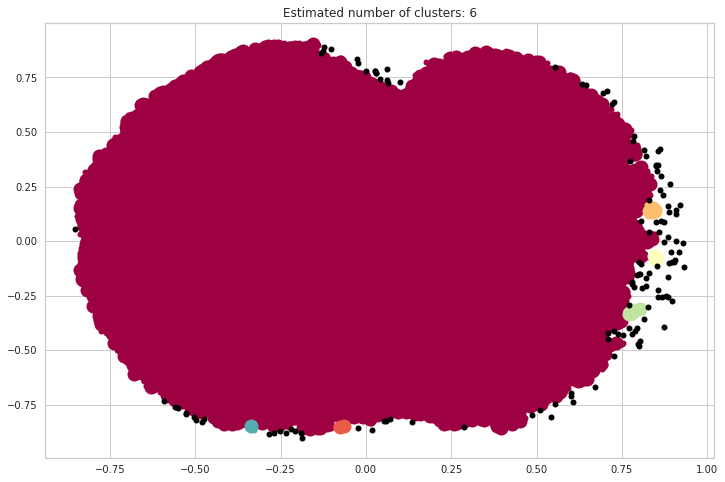

In [71]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_principal[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_principal[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## DBSCAN clustering de la donnée brute (sans PCA)

In [72]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.405, min_samples = 5).fit(X_normalized)
labels = db_default.labels_

In [73]:
np.unique(labels)

array([-1,  0,  1,  2])

In [74]:
# Step 5: Building the clustering model
from sklearn import metrics
labels_true = X.index
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.405, min_samples = 5).fit(X_normalized)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 613
Homogeneity: 0.0036
Completeness: 1.0000
V-measure: 0.0072
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: -0.0000
Silhouette Coefficient: 0.1653


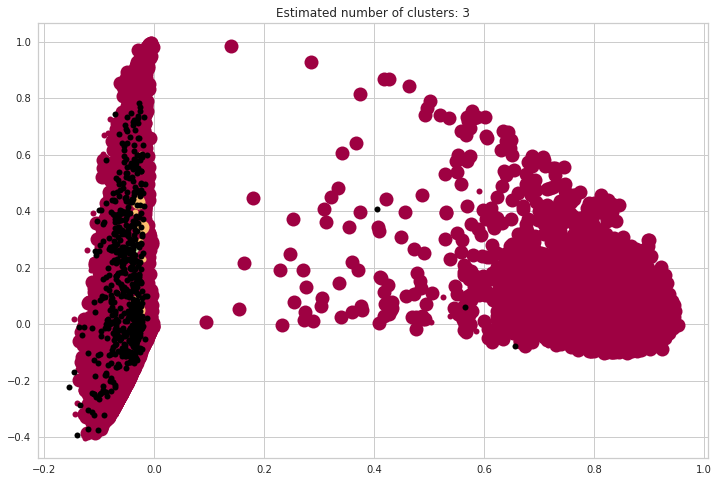

In [75]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_normalized[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_normalized[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Conclusion

## En conclusion on a partitionné notre data set clients en utilisant diffents algorithmes dont K-Means,K-Prototypes, Hierarchiqual agglomerative clustering selon Ward, et DBSCAN, les resultas malgre certainnes imperfections tournent autour de 5 a 6 clusters ,mais le plus probants quant au score (silhouette), fit-time,ainsi que son score à l'initialisation  est le modele K-Means dont on garde les resultats.

## Interprétation métier des clusters selon  K-Means

### Groupe 1 : Clients proches géographiquement avec de courts délais de livraison, commandant principalement en début d'année pour des montants faibles. Ils paient avec 1 type de moyen de paiement et avec un nombre faible d'échéances. Les avis de ces clients sont très bons.

### Groupe 2 : Clients de fin d'année. Ils règlent avec plusieurs moyens de paiement pour des montants faibles. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons.

### Groupe 3 : Regroupe les clients qui utilisent plusieurs moyens de paiement et un nombre important d'échéances. Ils ont tendence à espacer les délais entre 2 commandes. Les avis de ces clients sont également très bons.

### Groupe 4 : Ce sont des clients mécontants (les avis sont mauvais). Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont le plus dépensé et ont acheté un grand nombre d'articles. En revanche, le nombre de commandes passées sur le site est moyen.

### Groupe 5 : Ces clients ont passé un nombre important de commandes et sont satisfaits. ils paient comptant pour un montant moyen de commande. Ils sont géographiquement proches.

### Quant à la maintenance Il faudra donc prévoir celle du programme de segmentation tous les 6 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner,  en veillant à  redéfinir les segments clients à chaque maintenance.